In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from datetime import timedelta

In [2]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

def get_month_index(month):
    return months.index(month)+1

In [11]:
raw_data = pd.read_csv('hotel.csv', converters={'arrival_date_month': get_month_index},parse_dates=['reservation_status_date'])
raw_data.rename(columns={'arrival_date_year':'arrival_year', 'arrival_date_month':'arrival_month', 
'arrival_date_day_of_month':'arrival_day_of_month', 'arrival_date_week_number':'arrival_week_number'}, inplace=True)
pd.set_option('display.max_columns', None)
raw_data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_year', 'arrival_month',
       'arrival_week_number', 'arrival_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'will_cancel'],
      dtype='object')

## Data Engineering

In [12]:
# Null Handling

raw_data.agent.fillna(0, inplace=True)

raw_data.company.fillna(0, inplace=True)

raw_data.dropna(inplace=True)

In [13]:
def get_date(year,month,day):
    return str(year) + '-' + str(month) + '-' + str(day)

raw_data['arrival_date'] = raw_data.apply(lambda x: get_date(x['arrival_year'], x['arrival_month'], x['arrival_day_of_month']), axis=1)
raw_data['arrival_date'] = pd.to_datetime(raw_data['arrival_date'], format='%Y-%m-%d')
raw_data['arrival_day_of_week'] = raw_data['arrival_date'].dt.day_of_week

raw_data['booking_date'] = raw_data.apply(lambda x: x['arrival_date'] - timedelta(days=x['lead_time']), axis=1)
raw_data['booking_year'] = raw_data['booking_date'].dt.year
raw_data['booking_month'] = raw_data['booking_date'].dt.month
raw_data['booking_day_of_month'] = raw_data['booking_date'].dt.day
raw_data['booking_day_of_week'] = raw_data['booking_date'].dt.day_of_week
raw_data['booking_week_number'] = raw_data['booking_date'].dt.isocalendar().week

# def get_month_day(date):
#     return str(date)[5:]

# raw_data['arrival_day_month'] = raw_data.apply(lambda x: get_month_day(x['arrival_date']), axis=1)


# raw_data['booked'] = 1

raw_data['cancel_lead_time'] = (raw_data['arrival_date'] - raw_data['reservation_status_date']).dt.days
raw_data.loc[raw_data['cancel_lead_time'] < 0, 'cancel_lead_time'] = 0

# raw_data['stay_duration'] = (raw_data['reservation_status_date'] - raw_data['arrival_date']).dt.days


def family(value):
    if value > 0:
        return 1
    else:
        return 0

raw_data['is_family'] = raw_data.apply(lambda x: family(x['children'] + x['babies']), axis=1)

In [14]:
raw_data.head()

,hotel,is_canceled,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,will_cancel,arrival_date,arrival_day_of_week,booking_date,booking_year,booking_month,booking_day_of_month,booking_day_of_week,booking_week_number,cancel_lead_time,is_family
0,City Hotel,1,103,2015,7,29,18,2,1,2,0.0,0,HB,ITA,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,17.0,0.0,0,Transient-Party,94.50,0,0,Canceled,2015-07-16,1,2015-07-18,5,2015-04-06,2015,4,6,0,15,2,0
1,City Hotel,0,77,2016,5,19,1,2,0,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,0.0,0,Transient,125.10,1,0,Check-Out,2016-05-03,0,2016-05-01,6,2016-02-14,2016,2,14,6,6,0,0
2,City Hotel,0,125,2017,4,15,10,1,2,2,0.0,0,BB,IRL,Online TA,TA/TO,0,0,0,A,A,2,No Deposit,9.0,0.0,0,Transient,121.33,0,1,Check-Out,2017-04-13,1,2017-04-10,0,2016-12-06,2016,12,6,1,49,0,0
3,City Hotel,0,74,2017,1,3,18,0,4,2,0.0,0,BB,ARG,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,8.0,0.0,0,Transient,88.39,0,3,Check-Out,2017-01-22,0,2017-01-18,2,2016-11-05,2016,11,5,5,44,0,0
4,City Hotel,1,332,2015,9,38,14,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,0.0,0,Contract,62.00,0,0,Canceled,2015-01-01,1,2015-09-14,0,2014-10-17,2014,10,17,4,42,256,0


In [15]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34864 entries, 0 to 34876
Data columns (total 43 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   hotel                           34864 non-null  object        
 1   is_canceled                     34864 non-null  int64         
 2   lead_time                       34864 non-null  int64         
 3   arrival_year                    34864 non-null  int64         
 4   arrival_month                   34864 non-null  int64         
 5   arrival_week_number             34864 non-null  int64         
 6   arrival_day_of_month            34864 non-null  int64         
 7   stays_in_weekend_nights         34864 non-null  int64         
 8   stays_in_week_nights            34864 non-null  int64         
 9   adults                          34864 non-null  int64         
 10  children                        34864 non-null  float64       
 11  ba

In [16]:
raw_data.columns, len(raw_data.columns)

(Index(['hotel', 'is_canceled', 'lead_time', 'arrival_year', 'arrival_month',
        'arrival_week_number', 'arrival_day_of_month',
        'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
        'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
        'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'reserved_room_type',
        'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
        'company', 'days_in_waiting_list', 'customer_type', 'adr',
        'required_car_parking_spaces', 'total_of_special_requests',
        'reservation_status', 'reservation_status_date', 'will_cancel',
        'arrival_date', 'arrival_day_of_week', 'booking_date', 'booking_year',
        'booking_month', 'booking_day_of_month', 'booking_day_of_week',
        'booking_week_number', 'cancel_lead_time', 'is_family'],
       dtype='object'),
 43)

In [17]:
data = raw_data.drop(labels=['is_canceled','adr','reservation_status','reservation_status_date','arrival_date',
                    'booking_date'], axis=1)
data

,hotel,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,will_cancel,arrival_day_of_week,booking_year,booking_month,booking_day_of_month,booking_day_of_week,booking_week_number,cancel_lead_time,is_family
0,City Hotel,103,2015,7,29,18,2,1,2,0.0,0,HB,ITA,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,17.0,0.0,0,Transient-Party,0,0,1,5,2015,4,6,0,15,2,0
1,City Hotel,77,2016,5,19,1,2,0,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,0.0,0,Transient,1,0,0,6,2016,2,14,6,6,0,0
2,City Hotel,125,2017,4,15,10,1,2,2,0.0,0,BB,IRL,Online TA,TA/TO,0,0,0,A,A,2,No Deposit,9.0,0.0,0,Transient,0,1,1,0,2016,12,6,1,49,0,0
3,City Hotel,74,2017,1,3,18,0,4,2,0.0,0,BB,ARG,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,8.0,0.0,0,Transient,0,3,0,2,2016,11,5,5,44,0,0
4,City Hotel,332,2015,9,38,14,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,0.0,0,Contract,0,0,1,0,2014,10,17,4,42,256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34872,City Hotel,17,2015,9,39,26,2,2,2,0.0,0,BB,IRN,Groups,TA/TO,0,0,0,A,A,1,No Deposit,1.0,0.0,0,Transient-Party,0,0,0,5,2015,9,9,2,37,0,0
34873,City Hotel,524,2016,12,51,15,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1.0,0.0,0,Transient,0,0,1,3,2015,7,10,4,28,421,0
34874,City Hotel,1,2015,8,32,8,1,1,2,0.0,0,SC,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,0.0,0.0,0,Transient,0,0,0,5,2015,8,7,4,32,0,0
34875,City Hotel,170,2017,7,27,8,2,1,2,0.0,0,BB,NOR,Online TA,TA/TO,0,0,0,D,A,0,No Deposit,9.0,0.0,0,Transient-Party,0,1,0,5,2017,1,19,3,3,0,0


In [18]:
city_data = data[data['hotel'] == 'City Hotel'].drop(labels='hotel',axis=1)
resort_data = data[data['hotel'] == 'Resort Hotel'].drop(labels='hotel',axis=1)

In [19]:
prepared_data = city_data
prepared_data

,lead_time,arrival_year,arrival_month,arrival_week_number,arrival_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,will_cancel,arrival_day_of_week,booking_year,booking_month,booking_day_of_month,booking_day_of_week,booking_week_number,cancel_lead_time,is_family
0,103,2015,7,29,18,2,1,2,0.0,0,HB,ITA,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,17.0,0.0,0,Transient-Party,0,0,1,5,2015,4,6,0,15,2,0
1,77,2016,5,19,1,2,0,2,0.0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,0.0,0,Transient,1,0,0,6,2016,2,14,6,6,0,0
2,125,2017,4,15,10,1,2,2,0.0,0,BB,IRL,Online TA,TA/TO,0,0,0,A,A,2,No Deposit,9.0,0.0,0,Transient,0,1,1,0,2016,12,6,1,49,0,0
3,74,2017,1,3,18,0,4,2,0.0,0,BB,ARG,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,8.0,0.0,0,Transient,0,3,0,2,2016,11,5,5,44,0,0
4,332,2015,9,38,14,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,0.0,0,Contract,0,0,1,0,2014,10,17,4,42,256,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34872,17,2015,9,39,26,2,2,2,0.0,0,BB,IRN,Groups,TA/TO,0,0,0,A,A,1,No Deposit,1.0,0.0,0,Transient-Party,0,0,0,5,2015,9,9,2,37,0,0
34873,524,2016,12,51,15,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,1.0,0.0,0,Transient,0,0,1,3,2015,7,10,4,28,421,0
34874,1,2015,8,32,8,1,1,2,0.0,0,SC,PRT,Direct,Direct,0,0,0,A,A,1,No Deposit,0.0,0.0,0,Transient,0,0,0,5,2015,8,7,4,32,0,0
34875,170,2017,7,27,8,2,1,2,0.0,0,BB,NOR,Online TA,TA/TO,0,0,0,D,A,0,No Deposit,9.0,0.0,0,Transient-Party,0,1,0,5,2017,1,19,3,3,0,0


In [20]:
timeseries_labels = ['arrival_month','arrival_week_number','arrival_day_of_month','arrival_day_of_week',
                'booking_month', 'booking_week_number', 'booking_day_of_month', 'booking_day_of_week']

for label in timeseries_labels:
    prepared_data[label + "_norm"] = 2 * math.pi * prepared_data[label] / prepared_data[label].max()
    prepared_data["cos_" + label] = np.cos(prepared_data[label + "_norm"])
    prepared_data["sin_" + label] = np.sin(prepared_data[label + "_norm"])

    prepared_data.drop(labels=[label + '_norm', label], axis=1, inplace=True)

In [21]:
prepared_data.columns, len(prepared_data.columns)

(Index(['lead_time', 'arrival_year', 'stays_in_weekend_nights',
        'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
        'country', 'market_segment', 'distribution_channel',
        'is_repeated_guest', 'previous_cancellations',
        'previous_bookings_not_canceled', 'reserved_room_type',
        'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
        'company', 'days_in_waiting_list', 'customer_type',
        'required_car_parking_spaces', 'total_of_special_requests',
        'will_cancel', 'booking_year', 'cancel_lead_time', 'is_family',
        'cos_arrival_month', 'sin_arrival_month', 'cos_arrival_week_number',
        'sin_arrival_week_number', 'cos_arrival_day_of_month',
        'sin_arrival_day_of_month', 'cos_arrival_day_of_week',
        'sin_arrival_day_of_week', 'cos_booking_month', 'sin_booking_month',
        'cos_booking_day_of_month', 'sin_booking_day_of_month',
        'cos_booking_day_of_week', 'sin_booking_day_of_week',
    

In [25]:
prepared_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34864 entries, 0 to 34876
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   lead_time                       34864 non-null  int64  
 1   arrival_year                    34864 non-null  int64  
 2   stays_in_weekend_nights         34864 non-null  int64  
 3   stays_in_week_nights            34864 non-null  int64  
 4   adults                          34864 non-null  int64  
 5   children                        34864 non-null  float64
 6   babies                          34864 non-null  int64  
 7   meal                            34864 non-null  object 
 8   country                         34864 non-null  object 
 9   market_segment                  34864 non-null  object 
 10  distribution_channel            34864 non-null  object 
 11  is_repeated_guest               34864 non-null  int64  
 12  previous_cancellations          

In [23]:
## Categorical Data

cat_columns = ['meal','country','market_segment','distribution_channel','reserved_room_type','assigned_room_type','deposit_type','customer_type']
cat_data = prepared_data[cat_columns]

In [119]:
## Numerical Data

num_data = prepared_data.drop(labels=cat_columns+['cancel_lead_time'],axis=1)
columns = num_data.columns
num_data = num_data.to_numpy()
num_data

array([[6, 2015, 0, ..., 1.2246467991473532e-16, -0.9982437317643215,
        0.05924062789371414],
       [88, 2015, 0, ..., -0.8660254037844386, -0.08879589532293478,
        0.9960498426152169],
       [65, 2015, 0, ..., 0.0, -0.5338233779647907, 0.8455960035018261],
       ...,
       [34, 2017, 2, ..., -0.8660254037844384, -0.9151456172430186,
        -0.403123429287972],
       [109, 2017, 2, ..., -2.4492935982947064e-16, -0.630087843581711,
        0.7765238627180424],
       [205, 2017, 2, ..., -2.4492935982947064e-16, 0.8294056854502018,
        0.5586467658036525]], dtype=object)

In [120]:
encoder = OneHotEncoder(sparse=True,drop='first').fit(cat_data)
cat_data = encoder.transform(cat_data).toarray()
cat_data.shape

(79302, 197)

In [121]:
encoder.categories_

[array(['BB', 'FB', 'HB', 'SC'], dtype=object),
 array(['ABW', 'AGO', 'AIA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM',
        'ATA', 'ATF', 'AUS', 'AUT', 'AZE', 'BEL', 'BEN', 'BFA', 'BGD',
        'BGR', 'BHR', 'BIH', 'BLR', 'BOL', 'BRA', 'BRB', 'CAF', 'CHE',
        'CHL', 'CHN', 'CIV', 'CMR', 'CN', 'COL', 'COM', 'CPV', 'CRI',
        'CUB', 'CYP', 'CZE', 'DEU', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU',
        'EGY', 'ESP', 'EST', 'ETH', 'FIN', 'FRA', 'FRO', 'GAB', 'GBR',
        'GEO', 'GGY', 'GHA', 'GIB', 'GLP', 'GNB', 'GRC', 'GTM', 'GUY',
        'HKG', 'HND', 'HRV', 'HUN', 'IDN', 'IMN', 'IND', 'IRL', 'IRN',
        'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ',
        'KEN', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBY',
        'LCA', 'LIE', 'LKA', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MCO',
        'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MOZ', 'MRT',
        'MUS', 'MYS', 'MYT', 'NAM', 'NCL', 'NGA', 'NIC', 'NLD', 'NOR',
        'NZL', 'OMN', 'PAK', '

In [122]:
encoded_data = np.concatenate((num_data,cat_data),axis=1)
encoded_data.shape

(79302, 231)

In [123]:
columns = columns.to_list()

for cat in encoder.categories_:
    columns.extend(cat[1:])

len(columns)

231

In [124]:
X = encoded_data
y = prepared_data['cancel_lead_time']

In [125]:
X.shape, y.shape

((79302, 231), (79302,))

In [129]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [130]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((63441, 231), (63441,), (15861, 231), (15861,))

## Model Selection

In [131]:
from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,confusion_matrix
from math import sqrt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [132]:
def test_model(model):
    model.fit(X_train,y_train)
    print(model)
    y_pred = model.predict(X_test)

    print(f'RMSE: {sqrt(mean_squared_error(y_test,y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_test,y_pred)}')

    print(f'Train score: {model.score(X_train,y_train)}')
    print(f'Test score: {model.score(X_test,y_test)}')

In [133]:
def plot_error(model):
    n = 500
    pred = model.predict(X_test[:n])
    pred = pred.round()
    test = y_test[:n].values

    fig,ax = plt.subplots(figsize=(20,7))

    predictions = pd.DataFrame()
    predictions['X'] = X_test[:n,0]
    predictions['test'] = test[:n]
    predictions['pred'] = pred[:n]
    predictions.sort_values('test',axis=0,inplace=True)
    predictions.reset_index(drop=True,inplace=True)

    # sns.lineplot(x=predictions.index,y='X',data=predictions,ax=ax)
    sns.lineplot(x=predictions.index,y='test',data=predictions,ax=ax,label='Actual')
    sns.lineplot(x=predictions.index,y='pred',data=predictions,ax=ax,label='Predicted')
    ax.title.set_text(model)
    fig.legend(loc="upper right")

LinearRegression()
RMSE: 47.44896225892206
MAPE: 6.4324655831382776e+16
Train score: 0.5980649530394716
Test score: 0.5894162423061842


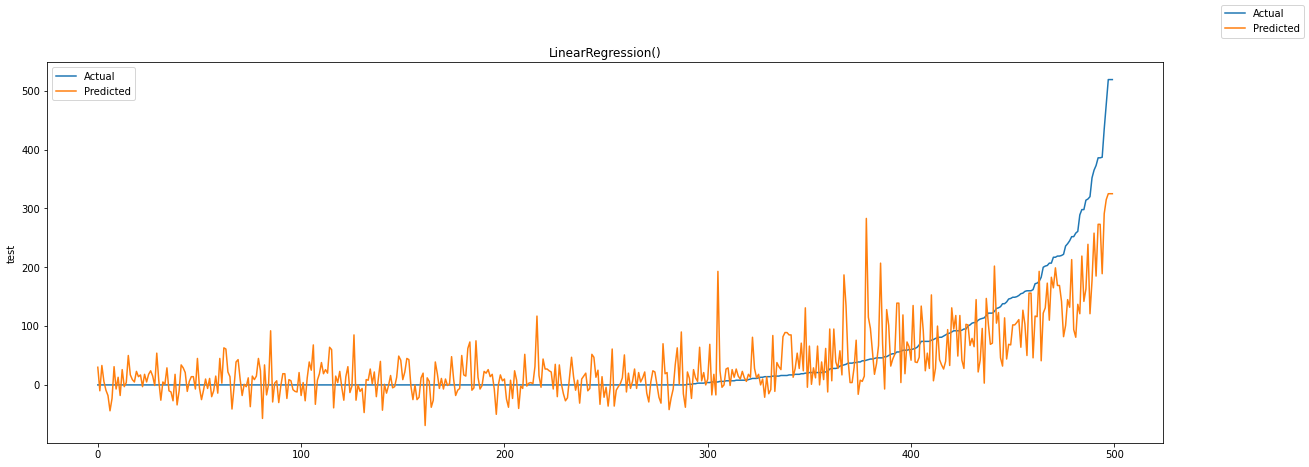

In [134]:
lin_reg = LinearRegression()
test_model(lin_reg)
plot_error(lin_reg)

Ridge()
RMSE: 47.421079209383954
MAPE: 6.428500212816215e+16
Train score: 0.5980167977311368
Test score: 0.5898986538467483


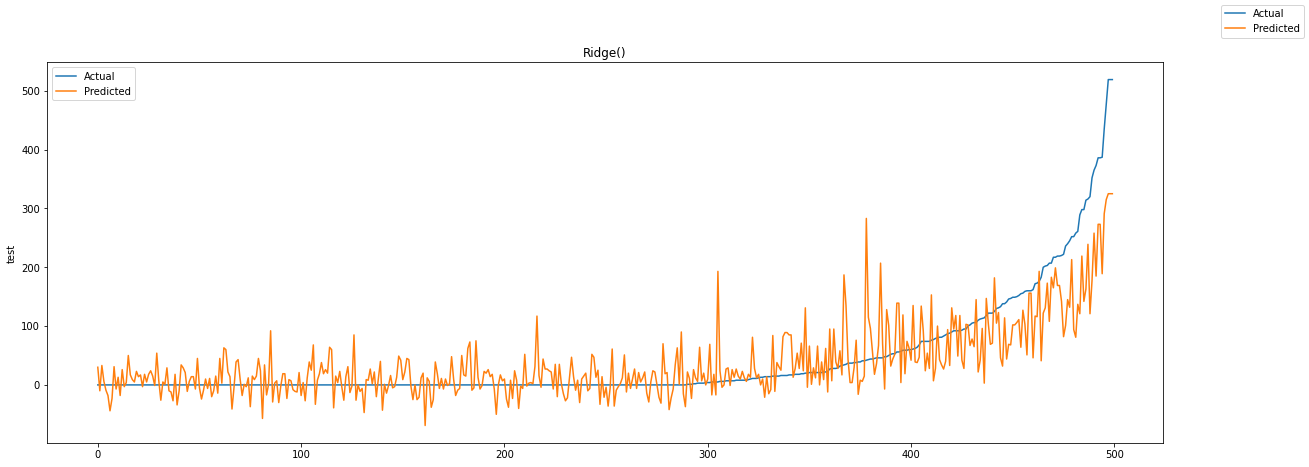

In [135]:
ridge_reg = Ridge()
test_model(ridge_reg)
plot_error(ridge_reg)

Lasso()
RMSE: 48.75806886721499
MAPE: 6.156269017446087e+16
Train score: 0.5724713323877022
Test score: 0.5664478733441285


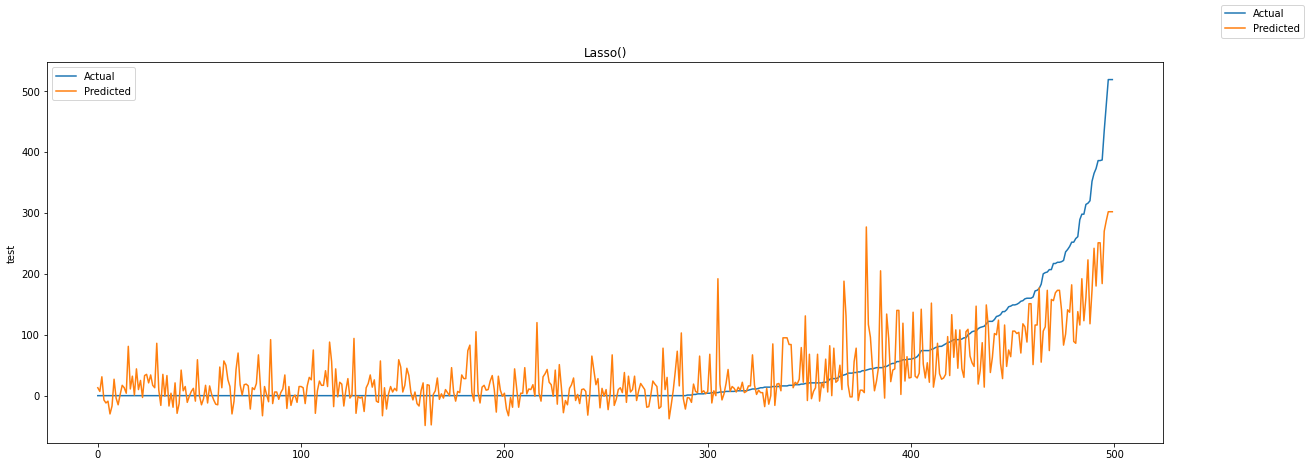

In [136]:
lasso_reg = Lasso()
test_model(lasso_reg)
plot_error(lasso_reg)

DecisionTreeRegressor()
RMSE: 31.35183496933823
MAPE: 1.7427738359553344e+16
Train score: 0.9981260151673381
Test score: 0.8207437706374188


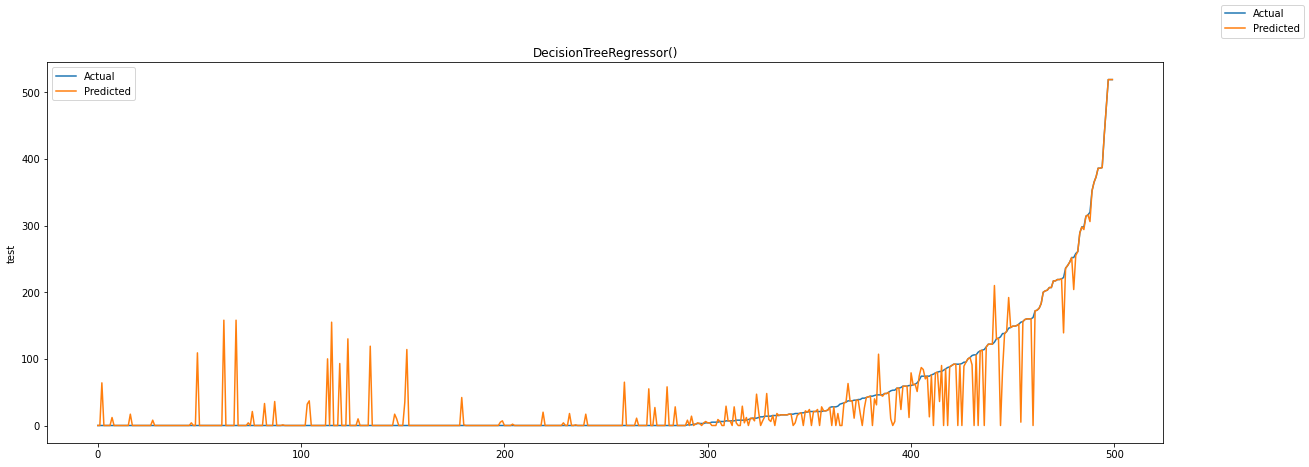

In [137]:
dec_tree = DecisionTreeRegressor()
test_model(dec_tree)
plot_error(dec_tree)

RandomForestRegressor(n_estimators=200, n_jobs=10)
RMSE: 23.02534455288403
MAPE: 1.9360087140538212e+16
Train score: 0.9852588791740895
Test score: 0.9033146656408246


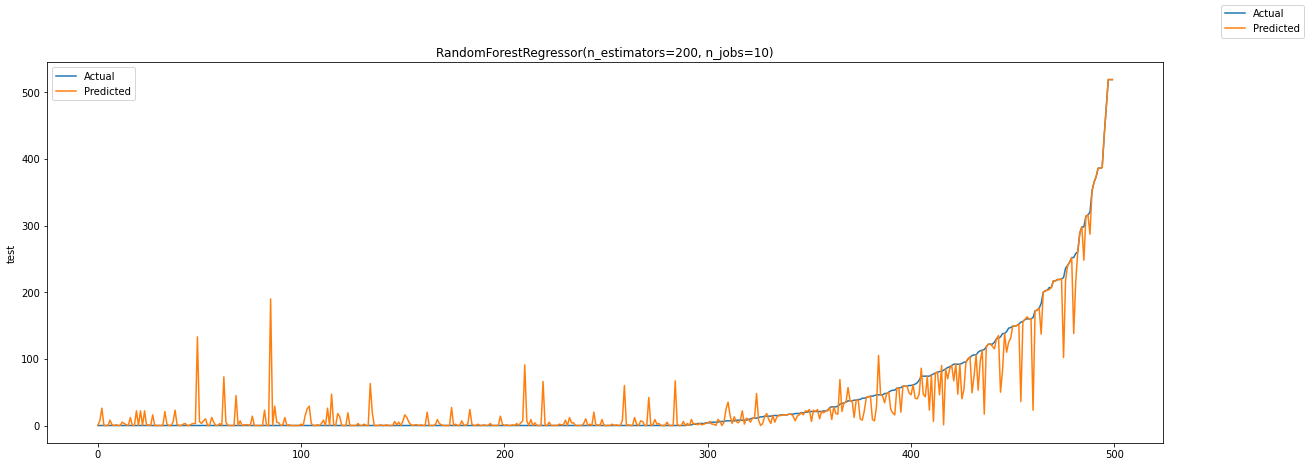

In [138]:
forest_reg = RandomForestRegressor(n_estimators=200,n_jobs=10)
test_model(forest_reg)
plot_error(forest_reg)

In [37]:
# reg = AdaBoostRegressor(n_jobs=10)
# params = dict(
#     n_estimators = [50,120,140,160,180,200,220,250],
#     criterion = ["squared_error", "absolute_error", "poisson"],
#     # min_samples_split = [1,2,3,4,5],
#     # max_features = [1,2,3,4,5],
#     # max_leaf_nodes = [1,2,3,4,5],
# )

# reg = RandomizedSearchCV(reg, params, random_state=0, verbose=1,error_score='raise')
# search = reg.fit(X_train,y_train)
# search.best_params_
# search.best_score_

AdaBoostRegressor(learning_rate=0.3, n_estimators=200, random_state=0)
RMSE: 49.012798795577446
MAPE: 7.737237554397582e+16
Train score: 0.574615040818512
Test score: 0.5619059712237493


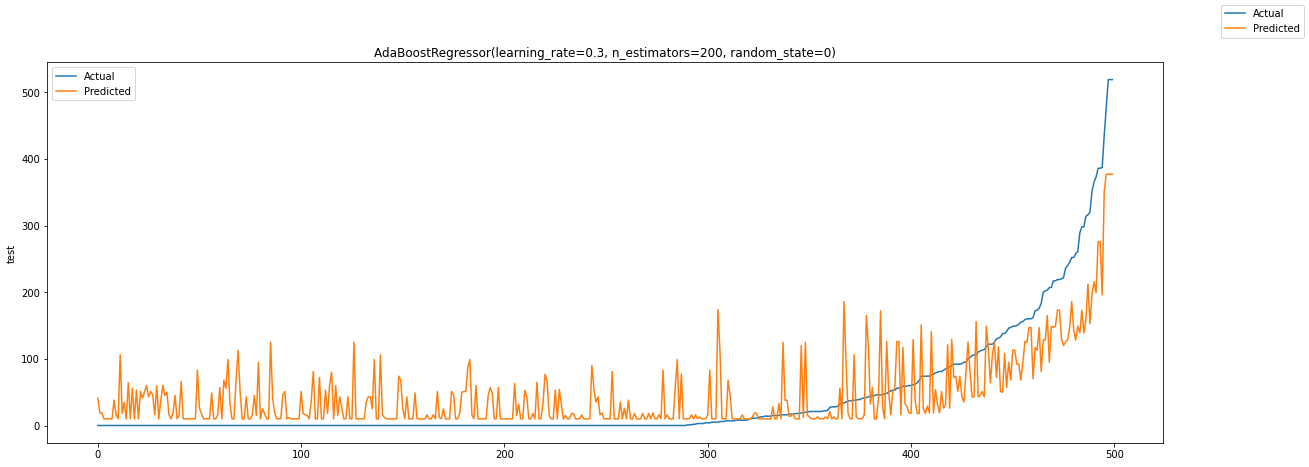

In [38]:
ada_reg = AdaBoostRegressor(learning_rate=0.3, n_estimators=200, random_state=0)
test_model(ada_reg)
plot_error(ada_reg)

GradientBoostingRegressor(max_depth=10, min_samples_split=5, n_estimators=81,
                          random_state=0)
RMSE: 24.49184493194078
MAPE: 2.2220958884110148e+16
Train score: 0.9288723034817561
Test score: 0.8906065472264514


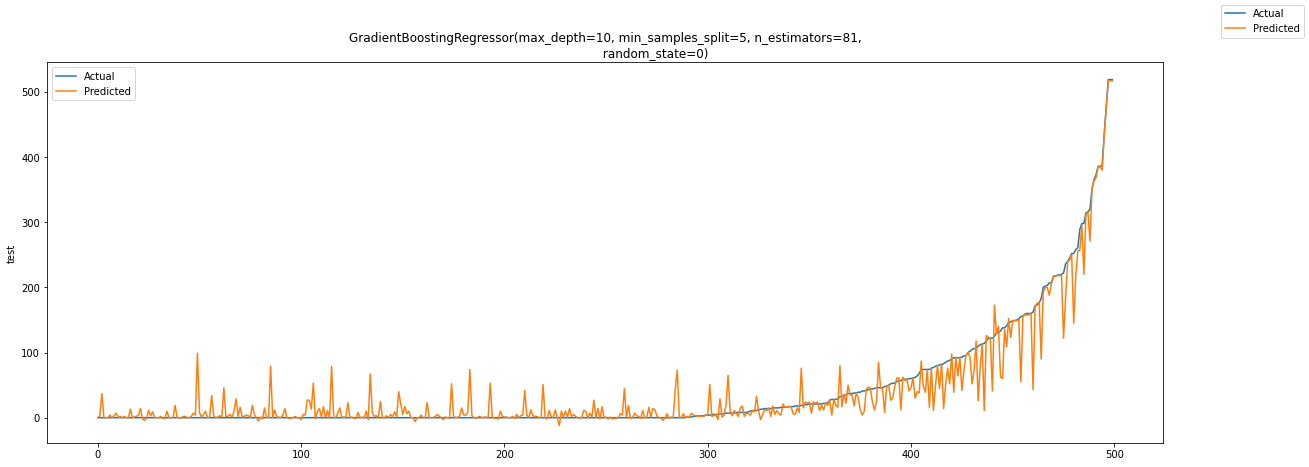

In [39]:
grad_boost = GradientBoostingRegressor(max_depth=10, min_samples_split=5, random_state=0, n_estimators=81)
test_model(grad_boost)
plot_error(grad_boost)

In [40]:
# import xgboost

In [41]:
# import xgboost

# xgb_reg = xgboost.XGBRegressor()
# test_model(xgb_reg)
# plot_error(xgb_reg)